В данной домашке предлагается воспроизвести результаты статьи https://arxiv.org/abs/2006.08545, изучающей поведение NF на Out-Of-Distribution (OOD) данных (т.е. тех данных, которые поток никогда не видел и которые находятся за пределом распределения обучающей выборки)


**(0.3 балла) Обучить Glow на CelebA, добиться нормального качества генерируемых картинок**


In [1]:
import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tqdm.notebook import tqdm as tqdm


%load_ext autoreload

%autoreload 2

# ! pip install wandb

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! gdown --id 1F96x4LDbsTZGMMq81fZr7aduJCe8N95O

import zipfile

path_to_zip = "/content/celeba.zip"


with zipfile.ZipFile(path_to_zip, 'r') as file:
    file.extractall(path='/content')

Downloading...
From: https://drive.google.com/uc?id=1F96x4LDbsTZGMMq81fZr7aduJCe8N95O
To: /content/celeba.zip
2.73GB [00:47, 57.9MB/s]


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

size = 32
celeba_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
    



In [3]:

celeba = torchvision.datasets.CelebA('/content/celeba',
                                           transform=celeba_transforms,
                                           download=False)

n = len(celeba)
t = int(n * 0.8)
train_set, val_set = torch.utils.data.random_split(celeba, [t, n - t])



In [53]:
b_s = 16

dataloader = torch.utils.data.DataLoader(train_set, b_s, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, 1, shuffle=False)

In [54]:
from inception import InceptionV3

fid_model = InceptionV3().to(device)

In [55]:
import wandb

project = 'GM HW4'

In [56]:
def calc_loss(log_p, logdet, image_size, n_bins):
    # log_p = calc_log_p([z_list])
    n_pixel = image_size * image_size * 3

    loss = -np.log(n_bins) * n_pixel
    loss = loss + logdet + log_p

    return (
        (-loss / (np.log(2) * n_pixel)).mean(),
        (log_p / (np.log(2) * n_pixel)).mean(),
        (logdet / (np.log(2) * n_pixel)).mean(),
    )



In [61]:
# Simple function for wandb logging
import random
from calculate_fid import calculate_fid


def generate_example(model, loader):
    model.eval()

    rand_index = random.randrange(len(loader.dataset))
    image, label = loader.dataset[rand_index]
    
    device = next(model.parameters()).device
    image = image.to(device).unsqueeze(0)
    
    with torch.no_grad():
        reconstructed_image = model.sample(1, 32)[0]
    
    reconstructed_image = torch.clamp(reconstructed_image, -1, 1)
    reconstructed_image = ((reconstructed_image.permute(1, 2, 0) + 1) / 2).cpu().numpy()
    

    example = {
               'reconstructed image': wandb.Image(reconstructed_image)
               }
    
    return example

def train(image, model, optimizer):
    model.train()
    optimizer.zero_grad()

    image = image * 255

    if n_bits < 8:
        image = torch.floor(image / 2 ** (8 - n_bits))

    image = image / n_bins - 0.5

    log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)

    logdet = logdet.mean()
    loss, log_p, log_det = calc_loss(log_p, logdet, size, n_bins)

    loss.backward()
    optimizer.step()

    return loss, log_p, log_det


def process_epoch(epoch, loader, model, optimizer):
    best_loss = 1000000.
    losses = []
    log_ps = []
    log_dets = []
    device = next(model.parameters()).device
    for i, (image, _) in tqdm(enumerate(loader), desc=f"trainloop: {epoch}", leave=False):
        image = image.to(device)
        
        loss, log_p, log_det = train(image, model, optimizer)
        losses.append(loss.item())
        log_ps.append(log_p.item())
        log_dets.append(log_det.item())
        
        if (i + 1) % 20 == 0:
            example = generate_example(model, loader)
            l = np.mean(losses)

                    
            example.update({'loss': np.mean(losses) / len(image),
                            'Log P': np.mean(log_ps) / len(image),
                            'Log Det': np.mean(log_dets) / len(image)
                            })
            

            losses = []
            log_ps = []
            log_dets = []
            # if (i + 1) % 400 == 0:
            #     fid = calculate_fid(image, model, fid_model)

            #     example.update({'FID': fid
            #                     })

            
            wandb.log(example)

            if (l < best_loss):
                best_loss = l
                torch.save(model.state_dict(), PATH + name + '.pt')


In [62]:
n_bits = 5
n_bins = 2.0 ** n_bits

In [4]:
from glow import Glow

name = 'Glow'

model = Glow(3, 16, 4).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
PATH = "/content/drive/MyDrive/"

In [5]:
load = True

if load:
    model.load_state_dict(torch.load(PATH + name + '.pt'))

In [60]:
 

wandb.init(project=project, name=name);
wandb.watch(model);


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
epochs = 10
for i in range(1, epochs + 1):
    process_epoch(i, dataloader, model, optim)


**(0.4 балла) Построить гистограмму лайклихудов для обученного в предыдущем пункте потока для данных CelebA (train), CelebA (test) и SVHN (OOD)**

In [30]:
def get_probs(loader, model, max_t=1e4 + 16):
    model.eval()

    log_ps = torch.zeros(int(max_t))
    device = next(model.parameters()).device
    with torch.no_grad():
      for i, (image, _) in tqdm(enumerate(loader)):
          image = image.to(device)
          

          log_p, _, _ = model(image)
          log_p = log_p.detach().cpu()
          try:
              log_ps[i * b_s:(i + 1) * b_s] = log_p
          except Exception as e:
              a = 0

          if (i * len(image) >= max_t):
              break

    return log_ps

In [32]:
b_s = 64

dataloader = torch.utils.data.DataLoader(train_set, b_s, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_set, b_s, shuffle=False)

In [33]:
svhn = torchvision.datasets.SVHN('/SVHN/', transform=celeba_transforms,
                                           download=True)

svhn_dataloader = torch.utils.data.DataLoader(svhn, b_s, shuffle=False)

Using downloaded and verified file: /SVHN/train_32x32.mat


In [34]:
log_ps_train = get_probs(dataloader, model, max_t=1e4)
log_ps_test = get_probs(val_dataloader, model, max_t=1e4)

In [35]:
log_ps_svhn = get_probs(svhn_dataloader, model, max_t=1e4)

In [36]:
log_ps_train = log_ps_train[:-16]
log_ps_test = log_ps_test[:-16]
log_ps_svhn = log_ps_svhn[:-16]

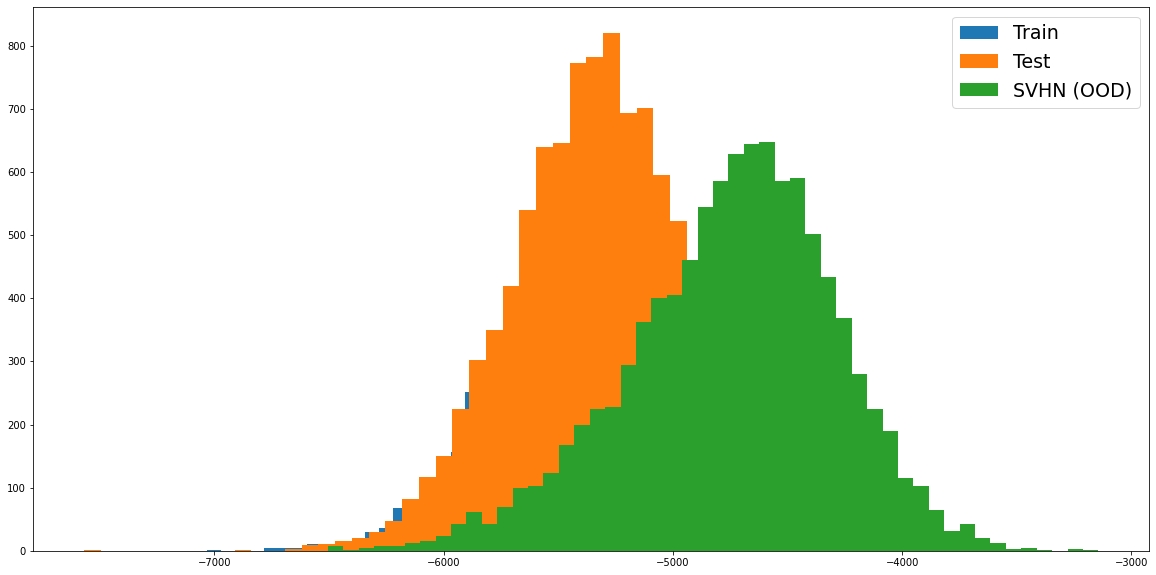

<Figure size 432x288 with 0 Axes>

In [38]:
plt.figure(figsize=(20, 10))
plt.hist(log_ps_train, bins=50, label='Train')
plt.hist(log_ps_test, bins=50, label='Test')
plt.hist(log_ps_svhn, bins=50, label='SVHN (OOD)')
plt.legend(fontsize=19)
plt.show()
plt.savefig('Distributions.pdf')

Замечание: из каждого датасета достаточно взять только некоторую долю объектов, достаточную для построения гистограммы

**(0.3 балла) Сравнить картинки из OOD (SVHN) с наибольшим предсказанным лайклихудом с картинками обучающего датасета (CelebA) с наименьшим лайклихудом. Что можно сказать об этих картинках? Почему лайклихуд первых может быть выше?**

In [20]:
def get_celeba_pics(loader, model, threshold=5000, n_pics=10):
    model.eval()

    images = []
    c = 0
    device = next(model.parameters()).device
    with torch.no_grad():
      for i, (image, _) in tqdm(enumerate(loader)):
          image = image.to(device)
          

          log_p, _, _ = model(image)
          log_p = log_p.detach().cpu()
          
          if torch.abs(log_p) > threshold:
              images.append(image[0].detach().cpu())
              c += 1

          if (c == n_pics):
              break

    return images


def get_svhn_pics(loader, model, threshold=5000, n_pics=10):
    model.eval()

    images = []
    c = 0
    device = next(model.parameters()).device
    with torch.no_grad():
      for i, (image, _) in tqdm(enumerate(loader)):
          image = image.to(device)
          

          log_p, _, _ = model(image)
          log_p = log_p.detach().cpu()
          
          if torch.abs(log_p) < threshold:
              images.append(image[0].detach().cpu())
              c += 1

          if (c == n_pics):
              break

    return images

In [9]:
dataloader = torch.utils.data.DataLoader(train_set, 1, shuffle=False)
svhn_dataloader = torch.utils.data.DataLoader(svhn, 1, shuffle=False)

In [21]:
celeba_pics = get_celeba_pics(dataloader, model, 6200, n_pics=10)

In [22]:
svhn_pics = get_svhn_pics(svhn_dataloader, model, 4000, n_pics=10)

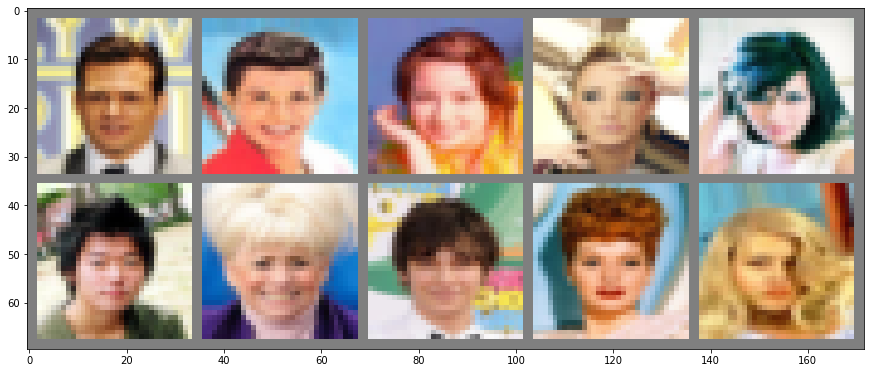

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid([celeba_pics[i] for i in range(10)], nrow=5).permute(1,2,0) * 0.5 + 0.5)
plt.show()
plt.savefig('celeba_worst.pdf')

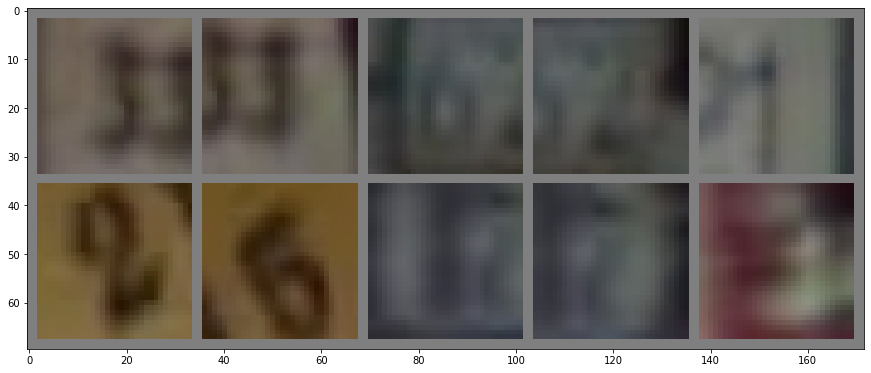

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(15,15))
plt.imshow(make_grid([svhn_pics[i] for i in range(10)], nrow=5).permute(1,2,0) * 0.5 + 0.5)
plt.show()
plt.savefig('svhn_best.pdf')